In [1]:
import os
import json
from shapely.geometry import shape, GeometryCollection, Point

os.environ['OBJC_DISABLE_INITIALIZE_FORK_SAFETY'] = 'YES'
os.environ['PYSPARK_PYTHON'] = 'python3'

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
from pyspark.sql.functions import unix_timestamp

spark = SparkSession \
    .builder \
    .appName("Analyzing Taxi trips") \
    .getOrCreate()

#### Reading external data as a dataframe

In [3]:
data = spark.read\
            .format("csv")\
            .option("header", "true")\
            .option("inferSchema", "true")\
            .load("Dataset/sample.csv")

In [4]:
data.printSchema()

root
 |-- medallion: string (nullable = true)
 |-- hack_license: string (nullable = true)
 |-- vendor_id: string (nullable = true)
 |-- rate_code: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_time_in_secs: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)



In [10]:
data = data.repartition(8)

In [31]:
data.count()

99999

In [12]:
data.rdd.getNumPartitions()

8

In [13]:
def getNullValues(data):
    for col in data.columns:
        print ('the count of null rows in column %s ' %col, data.where(F.col(col).isNull()).count())

In [14]:
getNullValues(data)

the count of null rows in column medallion  0
the count of null rows in column hack_license  0
the count of null rows in column vendor_id  0
the count of null rows in column rate_code  0
the count of null rows in column store_and_fwd_flag  99626
the count of null rows in column pickup_datetime  0
the count of null rows in column dropoff_datetime  0
the count of null rows in column passenger_count  0
the count of null rows in column trip_time_in_secs  0
the count of null rows in column trip_distance  0
the count of null rows in column pickup_longitude  0
the count of null rows in column pickup_latitude  0
the count of null rows in column dropoff_longitude  0
the count of null rows in column dropoff_latitude  0


# Geojson file

In [15]:
with open("Dataset/nyc-boroughs.geojson", 'r') as f:
    boroughs = json.load(f)

In [16]:
union_polygons = []

current_code = 0
current_name = ''
index = -1

for feature in boroughs['features']:
    if current_code == feature['properties']['boroughCode']:
        union_polygons[index]['polygon'] = union_polygons[index]['polygon'].union(shape(feature['geometry']))
        continue
    current_code = feature['properties']['boroughCode']
    current_name = feature['properties']['borough']
    union_polygons.append({'code':current_code,'name':current_name,'polygon':shape(feature['geometry'])})
    index+=1


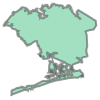

In [17]:
union_polygons[1]['polygon']

### broadcast Polygons to all workers to optimize 

In [18]:
sc = spark.sparkContext
broadcastUnion_polygons=sc.broadcast(union_polygons)

In [19]:
def getBorough(longt,latit):
    try:
        # ignore langitude and latitude has null values
        if  not longt or not latit:
            return '' + longt+ latit
        
        point = Point(float(longt), float(latit))
        for polygon_data in broadcastUnion_polygons.value:            
            # check if polygon has a point or not
            if polygon_data['polygon'].contains(point):
                return(polygon_data['name'])
    except:
        return None

In [20]:
getBorough(-73.978165,40.757977)

'Manhattan'

In [21]:
getBorough_udf = udf(getBorough, StringType())

## Clean Data:
   1. Get for pickup City and dropoff City and duration for the trip.
   2. Filter trips according to duration are neither negative or above 4 hours.


In [27]:
tripsDF = data.withColumn("pickup_city", getBorough_udf(data.pickup_longitude,data.pickup_latitude))\
                .withColumn("dropoff_city", getBorough_udf(data.dropoff_longitude,data.dropoff_latitude))\
                .withColumn("duration", unix_timestamp(data.dropoff_datetime) - unix_timestamp(data.pickup_datetime))

--------------------------------

In [23]:
threshold = 14400 # 4 hours

In [24]:
tripsDF = tripsDF.filter((tripsDF.duration > 0) & (tripsDF.duration < threshold)) 

## 1 - Get avarage time it takes for a taxi to finds next trip per distination borough:
   1. partition Data by car license.
   2. sort each partition by pickup time.
   3. lag dropoff datetime 1 step over the window.
   4. calculate time drive takes for a taxi to finds next trip (time_to_find_trip).
   5. Filter trips according to time_to_find_trip are neither negative or above 4 hours.
   6. calculate avarage time for each pickup city.

In [25]:
from pyspark.sql.window import Window
from pyspark.sql.functions import lag 

windowSpec  = Window.partitionBy("hack_license").orderBy("pickup_datetime")

In [26]:
tripsDF = tripsDF.withColumn("lag_dropoff_datetime",lag("dropoff_datetime",1).over(windowSpec)) 

In [52]:
tripsDF.select('hack_license','dropoff_datetime','pickup_datetime','lag_dropoff_datetime').limit(10).show()

+--------------------+-------------------+-------------------+--------------------+
|        hack_license|   dropoff_datetime|    pickup_datetime|lag_dropoff_datetime|
+--------------------+-------------------+-------------------+--------------------+
|02856AFC22881ABCA...|2013-01-13 02:51:00|2013-01-13 02:42:00|                null|
|02856AFC22881ABCA...|2013-01-13 03:41:00|2013-01-13 03:32:00| 2013-01-13 02:51:00|
|02856AFC22881ABCA...|2013-01-13 03:57:00|2013-01-13 03:44:00| 2013-01-13 03:41:00|
|03A2D28F831C5C3E5...|2013-01-13 08:00:00|2013-01-13 07:55:00|                null|
|03A2D28F831C5C3E5...|2013-01-13 09:36:00|2013-01-13 09:33:00| 2013-01-13 08:00:00|
|03A2D28F831C5C3E5...|2013-01-13 10:02:00|2013-01-13 09:47:00| 2013-01-13 09:36:00|
|03A2D28F831C5C3E5...|2013-01-13 11:20:00|2013-01-13 11:09:00| 2013-01-13 10:02:00|
|03A2D28F831C5C3E5...|2013-01-13 11:25:00|2013-01-13 11:22:00| 2013-01-13 11:20:00|
|03A2D28F831C5C3E5...|2013-01-13 12:12:00|2013-01-13 11:35:00| 2013-01-13 11

In [53]:
tripsDF = tripsDF.withColumn("time_to_find_trip",unix_timestamp(tripsDF.pickup_datetime) - unix_timestamp(tripsDF.lag_dropoff_datetime))

In [54]:
tripsDF = tripsDF.filter((tripsDF.time_to_find_trip > 0) & (tripsDF.time_to_find_trip < threshold)) 

In [55]:
tripsDF.select('hack_license','dropoff_datetime','pickup_datetime','lag_dropoff_datetime','time_to_find_trip').limit(10).show()

+--------------------+-------------------+-------------------+--------------------+-----------------+
|        hack_license|   dropoff_datetime|    pickup_datetime|lag_dropoff_datetime|time_to_find_trip|
+--------------------+-------------------+-------------------+--------------------+-----------------+
|02856AFC22881ABCA...|2013-01-13 03:41:00|2013-01-13 03:32:00| 2013-01-13 02:51:00|             2460|
|02856AFC22881ABCA...|2013-01-13 03:57:00|2013-01-13 03:44:00| 2013-01-13 03:41:00|              180|
|03A2D28F831C5C3E5...|2013-01-13 09:36:00|2013-01-13 09:33:00| 2013-01-13 08:00:00|             5580|
|03A2D28F831C5C3E5...|2013-01-13 10:02:00|2013-01-13 09:47:00| 2013-01-13 09:36:00|              660|
|03A2D28F831C5C3E5...|2013-01-13 11:20:00|2013-01-13 11:09:00| 2013-01-13 10:02:00|             4020|
|03A2D28F831C5C3E5...|2013-01-13 11:25:00|2013-01-13 11:22:00| 2013-01-13 11:20:00|              120|
|03A2D28F831C5C3E5...|2013-01-13 12:12:00|2013-01-13 11:35:00| 2013-01-13 11:25:00

In [ ]:
getNullValues(tripsDF)

the count of null rows in column medallion  0
the count of null rows in column hack_license  0
the count of null rows in column vendor_id  0
the count of null rows in column rate_code  0
the count of null rows in column store_and_fwd_flag  87181
the count of null rows in column pickup_datetime  0
the count of null rows in column dropoff_datetime  0
the count of null rows in column passenger_count  0
the count of null rows in column trip_time_in_secs  0
the count of null rows in column trip_distance  0
the count of null rows in column pickup_longitude  0
the count of null rows in column pickup_latitude  0
the count of null rows in column dropoff_longitude  0
the count of null rows in column dropoff_latitude  0


In [56]:
tripsDF.groupBy('dropoff_city')\
        .agg(
            F.avg('time_to_find_trip').alias('average_time')
        )\
        .show()

+-------------+------------------+
| dropoff_city|      average_time|
+-------------+------------------+
|       Queens| 1727.410639290714|
|         null|1536.4707724425887|
|     Brooklyn|1588.4101855507304|
|Staten Island|             780.0|
|    Manhattan| 980.5077672509685|
|        Bronx|1637.5451263537907|
+-------------+------------------+



### 2 - the numbers of trips that started and ended within the same borough.

In [28]:
tripsDF.where(tripsDF.pickup_city == tripsDF.dropoff_city).count()

86074

### 3 - the numbers of trips that started in one borough and ended in another one.

In [29]:
tripsDF.where(tripsDF.pickup_city != tripsDF.dropoff_city).count()

11433